# Alzheimers Progression Classifier using Coronal MRI

**Authors: Jacob Heyman, Mitch Krieger**
***
## Overview

### Business Problem

Current methods for diagnosing Alzheimers disease in patients displaying early signs of dementia are expensive, risky and require expert analysis.  Recent studies have shown that using MRI imaging to visualize neurodegeneration can be an alternative method of diagnosis.  While this method decreases expense and risk, MRI imaging for tissue atrophy still requires visual analysis, resulting in potential human error.  Using machine learning algorithms we plan on creating a classifying model that can be used to classify the progression of demensia in AD patients and be used as a primary diagnostic tool for further medical intervention.  In this project we aim to answer the following questions:

- What are some of the distinct features of the four classes of dementia?       
- Can we create a model that accuratly classifies AD MRI images?
- What model and method best reduces the number of false positive when classifying images?

### Data Understanding

**Import relevant libraries and packages**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score
np.random.seed(123)
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

**Read in Train Dataset for EDA**

In [2]:
directory = 'Alzheimer_s Dataset/'
test_directory = 'Alzheimer_s Dataset/test/'
train_directory = 'Alzheimer_s Dataset/train/'

In [100]:
data_train = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 5121, 
        seed = 123)

# separate images from labels
train_images, train_labels = next(data_train)
print('Found Classes: ',data_train.class_indices)

Found 5122 images belonging to 4 classes.
Found Classes:  {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


**Visualize Class Balance**

Simple bar plot shows high class imbalance particularly for moderately and mildy demented classes. This is not unusual for medical data because of manual labor required by medical experts and the rare nature of the minority class compared to the majority. Later, we will attempt to address using image augmentation.

In [109]:
sum(train_labels)

array([ 717.,   52., 2561., 1791.], dtype=float32)

In [110]:
2561/sum(train_labels).sum()

0.5000976371802383

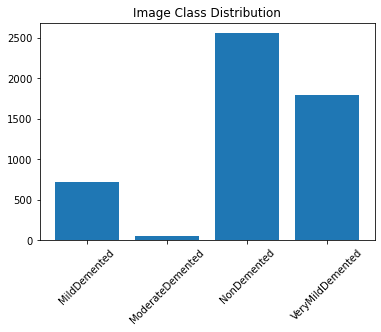

In [104]:
plt.bar(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'], sum(train_labels))
plt.xticks(rotation=45)
plt.title('Image Class Distribution');

**Visualize 9 sample images**

These sample 9 coronal brain MRI images show slight differences between classes that are difficult to detect for the average layperson. Small but noticable difference are the level of atrophy (black areas) around the edges of the cerebral cortex (outer layer of the brain)

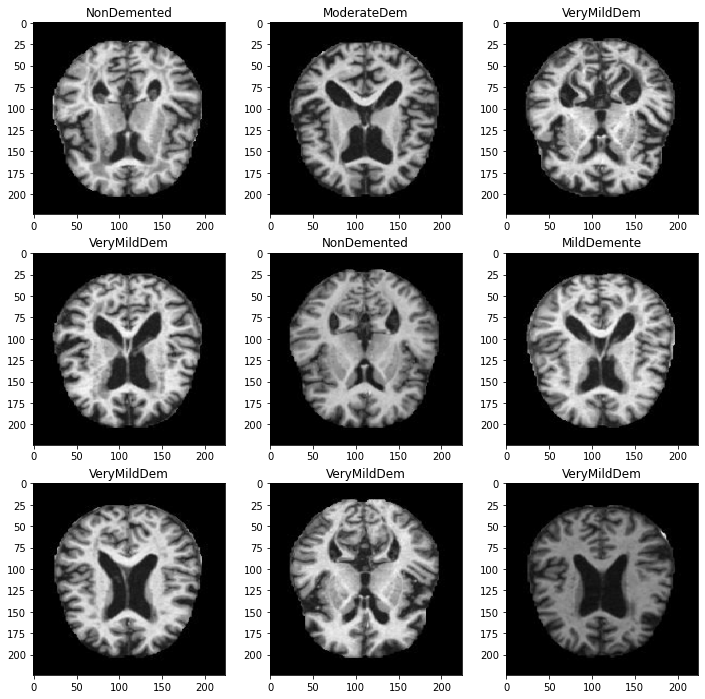

In [105]:
def get_label(array):
    if array[0] ==1:
        return 'MildDemented'
    elif array[1] ==1:
        return 'ModerateDemented'
    elif array[2] ==1:
        return 'NonDemented'
    elif array[3] ==1:
        return 'VeryMildDemented'

label_names = np.apply_along_axis(get_label,1,train_labels)

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))

for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_images[i])
  plt.gca().set_title(label_names[i])
plt.show()

In [25]:
#isolated milddemented class images for eda
data_mild = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 717, 
        seed = 123,
        classes= ['MildDemented'])

mild_images, mild_labels = next(data_mild)

Found 717 images belonging to 1 classes.


In [26]:
data_moderate = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 52, 
        seed = 123,
        classes= ['ModerateDemented'])

moderate_images, moderate_labels = next(data_moderate)

Found 52 images belonging to 1 classes.


In [27]:
data_NonD = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 2560, 
        seed = 123,
        classes= ['NonDemented'])

NonD_images, NonD_labels = next(data_NonD)

Found 2561 images belonging to 1 classes.


In [28]:
data_veryMild = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 1792, 
        seed = 123,
        classes= ['VeryMildDemented'])

veryMild_images, veryMild_labels = next(data_veryMild)

Found 1792 images belonging to 1 classes.


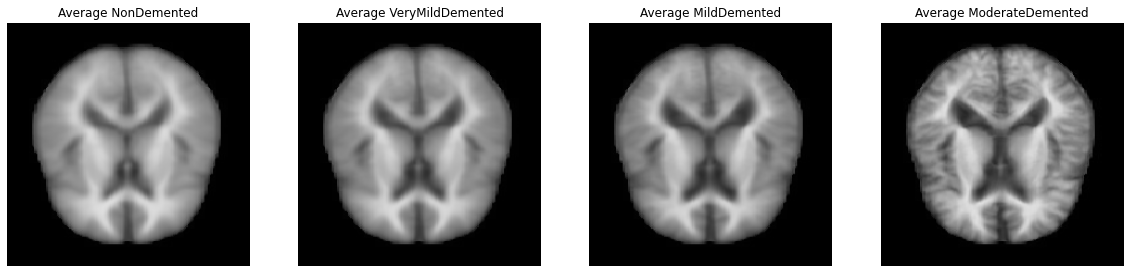

In [95]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5))

def find_mean_img(full_mat, ax, title, size = (224, 224)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    #mean_img = mean_img.reshape(size)
    ax.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    ax.set_title(f'Average {title}')
    ax.axis('off')
    return mean_img

NonD_mean = find_mean_img(NonD_images, ax[0], 'NonDemented')
veryMild_mean = find_mean_img(veryMild_images, ax[1],  'VeryMildDemented')
mild_mean = find_mean_img(mild_images,  ax[2], 'MildDemented')
Moderate_mean = find_mean_img(moderate_images,  ax[3], 'ModerateDemented')



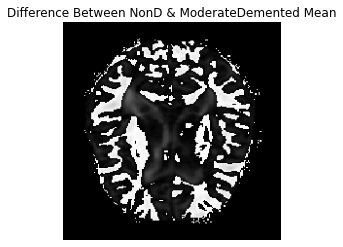

In [86]:
contrast_mean = NonD_mean - Moderate_mean
plt.imshow((contrast_mean*255).astype(np.uint8))
plt.title(f'Difference Between NonD & ModerateDemented Mean')
plt.axis('off')
plt.show()

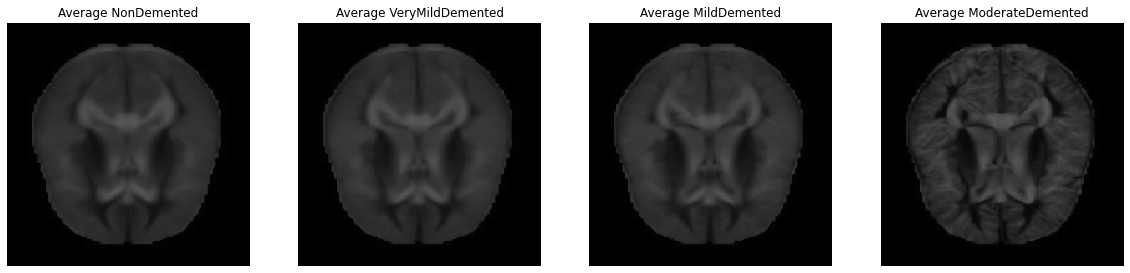

In [93]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5))

def find_std_img(full_mat, ax, title, size = (224, 224)):
    # calculate the average
    std_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    #mean_img = mean_img.reshape(size)
    ax.imshow(std_img, vmin=0, vmax=255, cmap='Greys_r')
    ax.set_title(f'Average {title}')
    ax.axis('off')
    return std_img

NonD_std = find_std_img(NonD_images, ax[0], 'NonDemented')
veryMild_std = find_std_img(veryMild_images, ax[1],'VeryMildDemented')
mild_std = find_std_img(mild_images, ax[2],'MildDemented')
Moderate_std = find_std_img(moderate_images,ax[3], 'ModerateDemented')

In [35]:
from sklearn.decomposition import PCA
from math import ceil

In [37]:
def eigenimages(full_mat, title, n_comp = 0.7):
    # fit PCA to describe n_comp * variability in the class
    size = (full_mat.shape[0],(224*224*3))
    array = np.reshape(full_mat, size)
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(array)
    print('Number of PC: ', pca.n_components_)
    return pca
  

    
non_eigan = eigenimages(NonD_images, 'NORMAL')
moderate_eigan= eigenimages(moderate_images, 'Moderate')

Number of PC:  81
Number of PC:  5


In [38]:
eigan_data = eigenimages(train_images, 'All')

Number of PC:  100


In [91]:
np.cumsum(eigan_data.explained_variance_ratio_[:5])

array([0.198734  , 0.2954595 , 0.36909124, 0.39565012, 0.4159412 ],
      dtype=float32)

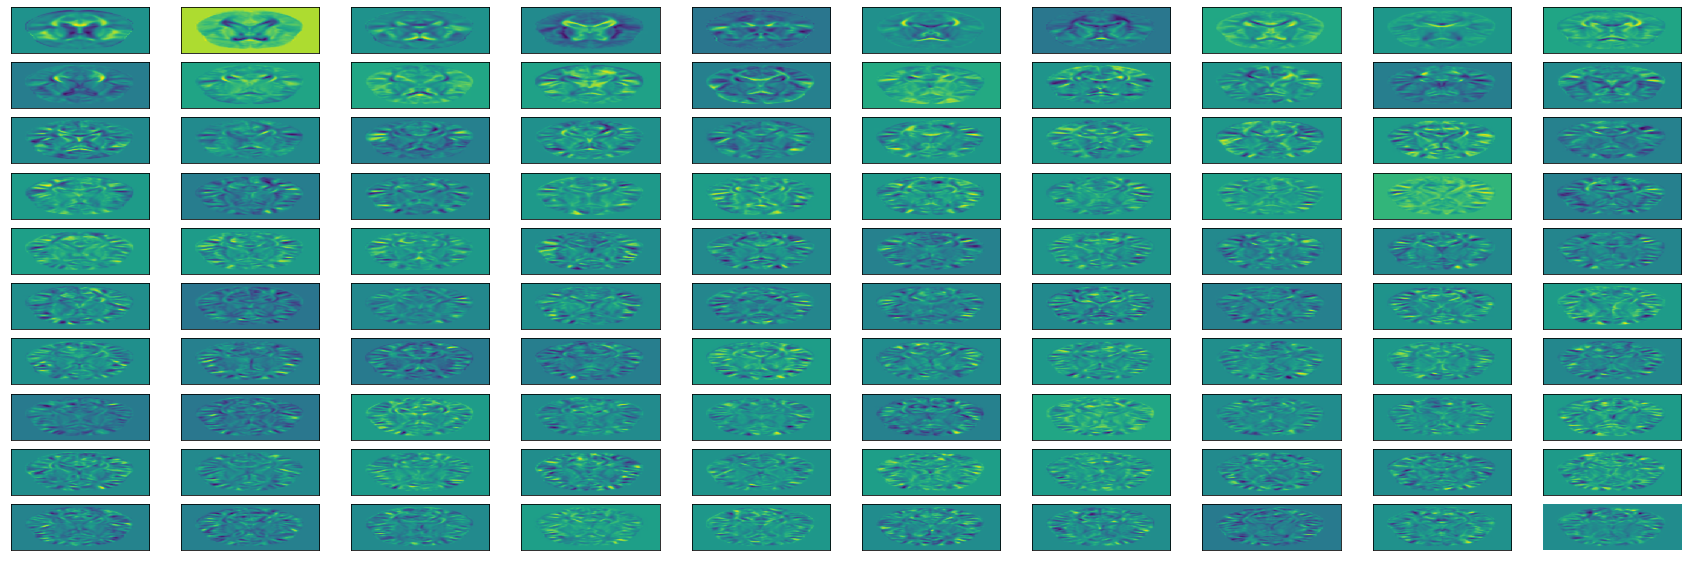

In [80]:
def plot_pca(pca):
    # plot eigenimages in a grid
    
    n = pca.n_components_
    fig = plt.figure(figsize=(30, 10))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(224,224*3), 
                  cmap='viridis')
    plt.axis('off')
    plt.show()
#plot_pca(non_eigan)
#plot_pca(moderate_eigan)
plot_pca(eigan_data)

In [102]:
from skimage.feature import hog
from skimage import exposure

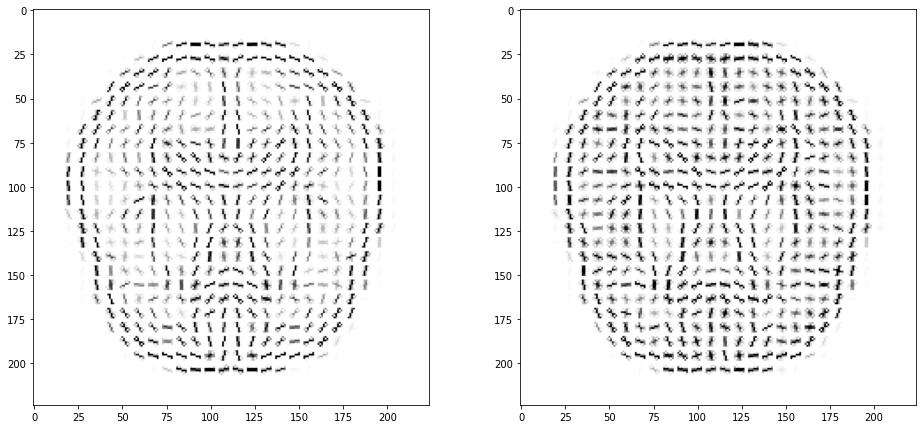

In [105]:
#histogram of oriented gradients
fd_NonD, NonD_hog = hog(NonD_mean, orientations=8, pixels_per_cell=(8,8),
                       cells_per_block=(3,3),visualize=True)
fd_moderate, moderate_hog = hog(Moderate_mean, orientations=8, pixels_per_cell=(8,8),
                       cells_per_block=(3,3),visualize=True)

NonD_hogs = exposure.rescale_intensity(NonD_hog, in_range=(0,0.04))
moderate_hogs = exposure.rescale_intensity(moderate_hog, in_range=(0,0.04))


fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(NonD_hogs, cmap='binary')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(moderate_hogs, cmap='binary')